In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import xgboost as xgb

from scipy.stats import skew

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LassoCV, Lasso

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.isna().sum()

In [3]:
all_data = pd.concat((df_train.loc[:, 'MSSubClass':'SaleCondition'], df_test.loc[:, 'MSSubClass':'SaleCondition']))

In [4]:
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

skewed_feats =(df_train[numeric_feats].dropna()).skew()
skewed_feats = skewed_feats[(abs(skewed_feats)) > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

C:\Users\samar\Miniconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log1p
  if __name__ == '__main__':


In [5]:
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

In [6]:
X_train = all_data[:df_train.shape[0]]
X_test = all_data[df_train.shape[0]:]
Y = df_train.SalePrice

In [7]:
def genrmse(model, xs, ys):
    rmse = np.sqrt(-cross_val_score(model, xs, ys, scoring = "neg_mean_squared_error", cv = 5))
    return(rmse)

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, Y, scoring = "neg_mean_squared_error", cv = 5))
    return(rmse)

In [8]:
ridge_alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in ridge_alphas]


0.12798179807510096


Text(0, 0.5, 'rmse')

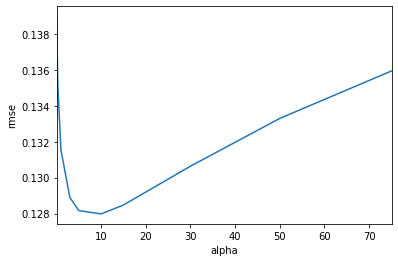

In [9]:
cv_ridge = pd.Series(cv_ridge, index = ridge_alphas)
cv_ridge_min = cv_ridge.min()
print(cv_ridge_min)
cv_ridge.plot()
plt.xlabel("alpha")
plt.ylabel("rmse")

In [10]:
poly = PolynomialFeatures(2)
dummy_train = X_train
dummy_Y = Y
PolyLasso = make_pipeline(PolynomialFeatures(2, interaction_only=True), Lasso())
genrmse(PolyLasso, dummy_train, dummy_Y).mean()


C:\Users\samar\Miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.736609945376318, tolerance: 0.018912592760396085
  positive)
C:\Users\samar\Miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.526630388096246, tolerance: 0.018002191385488822
  positive)
C:\Users\samar\Miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.357302614147457, tolerance: 0.018373605848561597
  positive)
C:\Users\samar\Miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

0.12408986631237924

In [11]:
model_lasso = LassoCV(alphas = [10, 1, 0.1, 0.001, 0.0005], cv = 5).fit(X_train, Y)
print(rmse_cv(model_lasso))
rmse_cv(model_lasso).mean()

[0.1034136  0.13179034 0.12514684 0.1060684  0.14765719]


0.12281527407493997

coef = pd.Series(model_lasso.coef_, index = X_train.columns)

coef_bad = coef[coef == 0]
coef_bad

coef_good = coef[coef != 0]
coef_good

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = pd.concat([coef.sort_values().head(20),
                     coef.sort_values().tail(20)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":Y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

dtrain = xgb.DMatrix(X_train, label = Y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, Y)

xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

preds = 0.7*lasso_preds + 0.3*xgb_preds

solution = pd.DataFrame({"id":df_test.Id, "SalePrice":preds})
solution.to_csv("Housing.csv", index = False)